In [1]:
import sys 
sys.path.append('r/Users/kostastsampourakis/Desktop/code/Python/projects/neuralssm')
from flax import nnx
import jax.numpy as jnp
import jax.random as jr
import jax
from jax import vmap
from flax import linen as nn
import matplotlib.pyplot as plt # creating visualizations

## Generate Data

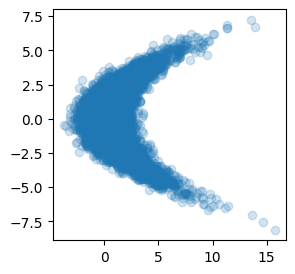

In [2]:
def generate_data_curved(key, n_samples):
  keys = jr.split(key, 2)
  epsilon = jr.normal(keys[0], shape=(n_samples, ))
  x_data = jr.uniform(keys[1], (n_samples, ), minval=-10.5, maxval=10.5)
  y_data = 7*jnp.sin(0.75*x_data) + 0.5*x_data + epsilon
  return jnp.array([x_data, y_data])

def generate_data_nl_gaussian(key, n_samples):
  keys = jr.split(key, 2)
  u  = jr.normal(keys[0], shape=(n_samples, 2))
  x = 2 * u[:, 0]
  y = x ** 2 / 4 + u[:, 1]
  return jnp.array([y, x])

def generate_circular_data(key, n_samples):
  keys = jr.split(key, 2)
  u = jr.uniform(keys[0], (n_samples, ))
  u1 = 0.1 * jr.normal(keys[1], (n_samples, 2))
  x = 2 * jnp.cos(2 * jnp.pi * u) + u1[:, 0]
  y = 2 * jnp.sin(2 * jnp.pi * u) + u1[:, 1]
  return jnp.array([x, y])
  
n_samples = batch_size = 10000 # just use train everything in a batch
gen = generate_data_nl_gaussian
data = gen(jr.PRNGKey(0), n_samples).T

# plot the original data and the test data
plt.figure(figsize=(3, 3))
plt.scatter(data[:,0], data[:,1], alpha=0.2)
plt.show()

In [3]:
dmean = jnp.mean(data, axis=0)
dvar = jnp.var(data, axis=0)
print(dmean, dvar)

[ 0.98729527 -0.00583494] [2.9410434 3.9579601]


## Testing BatchNorm

In [4]:
def bn_eval_inv(layer, u):
    """
    computes the inverse batch-normalizing transformation u->x
    """
    layer.eval()
    beta = layer.bias.value
    u_hat = (u - beta) / layer.scale.value
    x = u_hat * jnp.sqrt(layer.var.value + layer.epsilon) + layer.mean.value
    return x

### Train single BN layer

In [5]:
def loss_fn0(bn, x):
    num_samples = x.shape[0]
    us = bn(x)
    gamma = jnp.log(bn.scale.value)
    var = bn.var.value
    eps = bn.epsilon
    sum = jnp.sum(gamma)
    sum -= jnp.sum(jnp.log(var + eps)) / 2 
    return jnp.sum(us ** 2)/2 - num_samples * sum

In [6]:
model = nnx.BatchNorm(2, rngs=nnx.Rngs(0))
print(model.scale.value, model.bias.value, model.mean.value, model.var.value)

[1. 1.] [0. 0.] [0. 0.] [1. 1.]


In [7]:
import optax
from inference import MADE
key1, key2 = jr.split(jr.PRNGKey(0))

##### Search-relevant hyperparameters #########
din = 2
num_epochs = 3 * 1000
minibatch_size = 100
learning_rate = 1 * 1e-2
momentum = 0.9
lr_schedule = optax.schedules.exponential_decay(init_value=learning_rate, 
                                                decay_rate=0.9, 
                                                transition_steps=100, 
                                                transition_begin=500)
schedule = learning_rate
weight_decay = 1e-2

###############################################
optimizer = nnx.Optimizer(model, optax.adamw(schedule, momentum, weight_decay=weight_decay)) 



@nnx.jit  # automatic state management
def train_step(model, optimizer, data):
  loss_fn = lambda model: loss_fn0(model, data)
  loss, grads = nnx.value_and_grad(loss_fn)(model)
  optimizer.update(grads)  # inplace updates
  return loss

losses = []
keys = jr.split(key1, num_epochs)
for i in range(num_epochs):
  key, subkey = jr.split(keys[i])
  loss = train_step(model, optimizer, data)
  losses.append(loss)
  if i % 100 == 0:
    print(f'Epoch {i}, Loss {loss}')

Epoch 0, Loss 10241.9462890625
Epoch 100, Loss 19326.671875
Epoch 200, Loss 21292.462890625
Epoch 300, Loss 21924.849609375
Epoch 400, Loss 22146.640625
Epoch 500, Loss 22226.599609375
Epoch 600, Loss 22255.7109375
Epoch 700, Loss 22266.34375
Epoch 800, Loss 22270.232421875
Epoch 900, Loss 22271.65625
Epoch 1000, Loss 22272.17578125
Epoch 1100, Loss 22272.36328125
Epoch 1200, Loss 22272.43359375
Epoch 1300, Loss 22272.44140625
Epoch 1400, Loss 22272.44140625
Epoch 1500, Loss 22272.44140625
Epoch 1600, Loss 22272.44140625
Epoch 1700, Loss 22272.44140625
Epoch 1800, Loss 22272.44140625
Epoch 1900, Loss 22272.44140625
Epoch 2000, Loss 22272.44140625
Epoch 2100, Loss 22272.44140625
Epoch 2200, Loss 22272.44140625
Epoch 2300, Loss 22272.44140625
Epoch 2400, Loss 22272.44140625
Epoch 2500, Loss 22272.44140625
Epoch 2600, Loss 22272.44140625
Epoch 2700, Loss 22272.44140625
Epoch 2800, Loss 22272.44140625
Epoch 2900, Loss 22272.44140625


[ 0.98729527 -0.00583494] [2.9410434 3.9579601]
[0.9999987 0.9999991] [ 1.2979010e-07 -1.2725138e-06] [ 0.9872933  -0.00583492] [2.9410343 3.9579515]


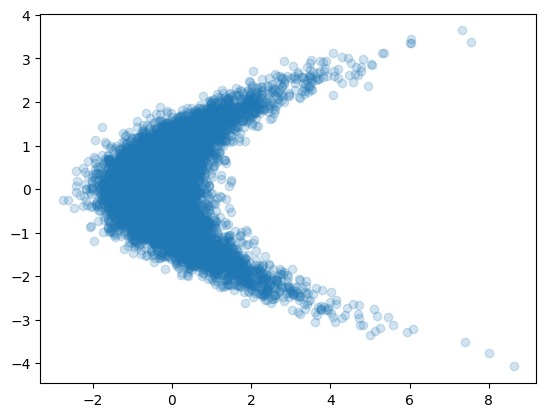

In [8]:
model.eval()
print(dmean, dvar)
print(model.scale.value, model.bias.value, model.mean.value, model.var.value)
us = model(data)
plt.scatter(us[:,0], us[:,1], alpha=0.2)
plt.show()

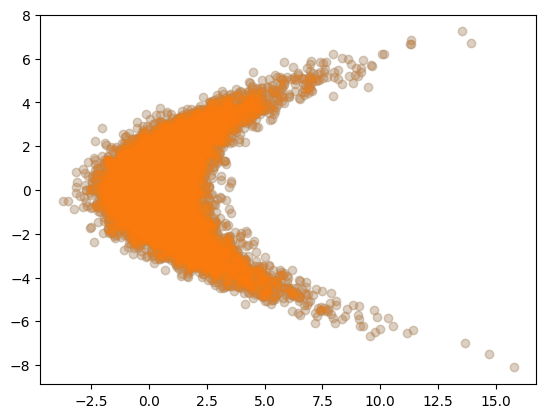

In [9]:
xs = bn_eval_inv(model, us)
plt.scatter(xs[:,0], xs[:,1], alpha=0.2)   
plt.scatter(data[:,0], data[:,1], alpha=0.2)
plt.show()

In [13]:
model.train()
model.use_running_average

False